In [53]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from collections import deque
import os
from scipy.spatial.transform import Rotation as R
import random
import cv2
os.environ["MUJOCO_GL"] = "egl"
torch.set_float32_matmul_precision('high')

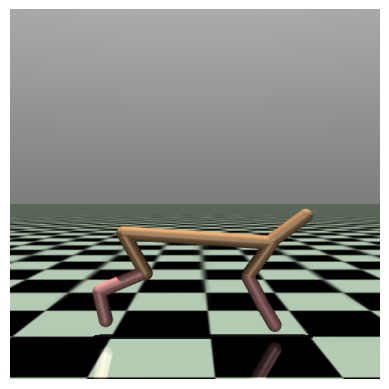

In [68]:
env = gym.make('HalfCheetah-v5', forward_reward_weight=2.0, ctrl_cost_weight=0.05, render_mode='rgb_array', exclude_current_positions_from_observation=False)
t = env.reset()[0]
image = env.render()
plt.imshow(image)
plt.axis('off')
plt.show()

In [69]:
class Value_Predictor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Value_Predictor, self).__init__()

        self.input_dim = state_dim + action_dim
        self.fc = nn.Sequential(
            nn.Linear(in_features=self.input_dim, out_features=128),
            nn.GELU(),
            nn.Linear(in_features=128, out_features=128),
            nn.GELU(),
            nn.Linear(in_features=128, out_features=256),
            nn.GELU(),
            nn.Linear(in_features=256, out_features=1)
        )
    def forward(self, x):
        return self.fc(x)
class Action_Predictor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Action_Predictor, self).__init__()

        self.input_dim = state_dim
        self.output_dim = action_dim
        self.fc = nn.Sequential(
            nn.Linear(in_features=self.input_dim, out_features=128),
            nn.GELU(),
            nn.Linear(in_features=128, out_features=128),
            nn.GELU(),
            nn.Linear(in_features=128, out_features=256),
            nn.GELU(),
            nn.Linear(in_features=256, out_features=self.output_dim),
            nn.Tanh()
        )
    def forward(self, x):
        return self.fc(x)

In [70]:
Q_Net = torch.compile(Value_Predictor(state_dim=18, action_dim=6)).to('cuda')
Policy_Net = torch.compile(Action_Predictor(state_dim=18, action_dim=6)).to('cuda')

Q_optimiser = optim.AdamW(params=Q_Net.parameters(), lr=1e-5)
P_optimiser = optim.AdamW(params=Policy_Net.parameters(), lr=1e-5)

criterion = nn.MSELoss()
Replay_Buffer = deque(maxlen=10000)

In [71]:
num_episodes = 50
epsilon = 1.0
epsilon_decay_factor = 0.9
gamma = 0.9
batch_size = 512
num_steps = 1000

In [93]:
Cumulative_Rewards = []

for episode in tqdm(range(num_episodes)):
    per_episode_reward = 0
    state = torch.tensor(env.reset()[0], dtype=torch.float32, device='cuda')

    for step_num in range(num_steps):
        with torch.no_grad():
            action = Policy_Net(state)
        noise = torch.normal(mean=0, std=epsilon, size=action.shape, device='cuda')
        action = torch.clamp(action + noise, -1, 1).cpu()
        next_state, reward, _, _, _ = env.step(action.numpy())
        
        per_episode_reward += reward

        state = state.cpu()
        next_state = torch.tensor(next_state, dtype=torch.float32)
        reward = torch.tensor(reward, dtype=torch.float32)
        experience = (state, action, reward, next_state)
        Replay_Buffer.append(experience)

        if len(Replay_Buffer) >= batch_size:

            batch = random.sample(Replay_Buffer, batch_size)
            states, actions, rewards, next_states = zip(*batch)
            states = torch.stack(states).to('cuda')
            actions = torch.stack(actions).to('cuda')
            next_states = torch.stack(next_states).to('cuda')
            rewards = torch.stack(rewards).to('cuda').unsqueeze(1)
            with torch.no_grad():
                mew_theta = Policy_Net(next_states)
                sa = torch.cat((next_states, mew_theta), dim=1)
                targets = rewards + gamma  * Q_Net(sa)
            sa = torch.cat((states, actions), dim=1)
            current_Q_vals = Q_Net(sa)
            loss = criterion(current_Q_vals, targets)
            Q_optimiser.zero_grad()
            loss.backward()
            Q_optimiser.step()

            mew_theta = Policy_Net(states)
            sa = torch.cat((states, mew_theta), dim=1)
            Q_vals = Q_Net(sa)
            P_optimiser.zero_grad()
            loss_p_net = -Q_vals.mean()
            loss_p_net.backward()
            P_optimiser.step()
    
        state = next_state.to('cuda')
    Cumulative_Rewards.append(per_episode_reward)
    
    epsilon = max(epsilon * epsilon_decay_factor, 0.01)

100%|██████████| 50/50 [07:24<00:00,  8.88s/it]


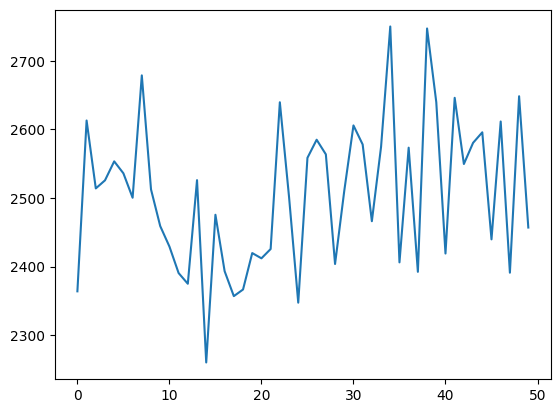

In [94]:
plt.plot(Cumulative_Rewards)
plt.show()

In [95]:
state = torch.tensor(env.reset()[0], dtype=torch.float32)
Images_List = [env.render()]
X_Coords = []
Z_Coords = []
with torch.no_grad():
    for _ in tqdm(range(1000)):
        action = Policy_Net(state.to('cuda'))
        state, reward, _, _, pos = env.step(action.cpu().numpy())
        state = torch.tensor(state, dtype=torch.float32, device='cuda')
        Images_List.append(env.render())
        x_coord = state[-1].cpu().item()
        z_coord = state[0].cpu().item()
        X_Coords.append(x_coord)
        Z_Coords.append(z_coord)

100%|██████████| 1000/1000 [00:01<00:00, 500.40it/s]


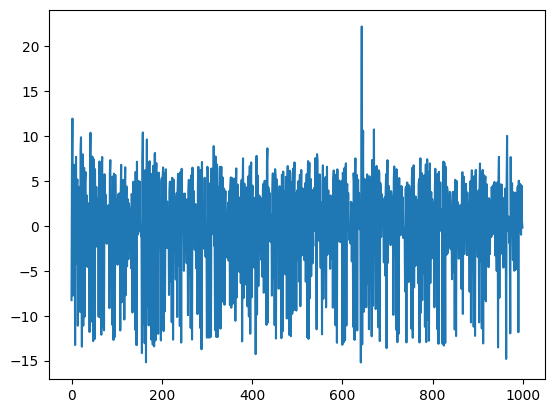

In [96]:
plt.plot(X_Coords)
plt.show()

In [97]:
def save_video_from_images(image_list, output_path, fps=30):
    if not image_list:
        raise ValueError("The image list is empty.")

    height, width, channels = image_list[0].shape
    if channels not in [1, 3]:
        raise ValueError("Images should have 1 or 3 channels (grayscale or RGB).")

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for img in image_list:
        if img.dtype != np.uint8:
            img = np.clip(img * 255, 0, 255).astype(np.uint8)

        if len(img.shape) == 2 or img.shape[2] == 1:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        
        video_writer.write(img)

    video_writer.release()
    print(f"Video saved at {output_path}")


In [98]:
output_path = "/home/arnabdey/Placement_ML_projects/RL/Cheetah_Runner.mp4"
save_video_from_images(Images_List, output_path, fps=30)

Video saved at /home/arnabdey/Placement_ML_projects/RL/Cheetah_Runner.mp4


In [99]:
torch.save(Q_Net.state_dict(), "/home/arnabdey/Placement_ML_projects/RL/Cheetah_Q.pth")
torch.save(Policy_Net.state_dict(), "/home/arnabdey/Placement_ML_projects/RL/Cheetah_P.pth")